In [2]:
import mne
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.pipeline import make_pipeline
# from sklearn import preprocessing
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression
from mne_bids import BIDSPath, read_raw_bids
# from mne.decoding import SlidingEstimator, cross_val_multiscore
from bids import BIDSLayout
# from mne.minimum_norm import (apply_inverse, apply_inverse_epochs,
#                               read_inverse_operator)
from mne_connectivity import seed_target_indices, spectral_connectivity_time

In [3]:
BIDS_ROOT = '../data/bids'
FIGS_ROOT = '../figs'
DERIV_ROOT = '../data/bids/derivatives'
FS = 5000
RAW_TMIN = -0.2
RAW_TMAX = 0.5
TMIN = 0
TMAX = 0.25
FREQS = [50, 100, 150, 200, 250]

In [4]:
layout = BIDSLayout(BIDS_ROOT, derivatives = True)
fpaths = layout.get(scope = 'preprocessing',
                    res = 'hi',
                    suffix='epo',
                    extension = 'fif.gz',
                    return_type = 'filename')

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


In [5]:
epochs = mne.read_epochs(fpaths[10], preload = True)
events = epochs.events
n_epochs = len(events)

Reading /project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocessing/sub-9/sub-9_task-pitch_run-1_res-hi_desc-clean_epo.fif.gz ...
    Found the data of interest:
        t =    -200.00 ...     250.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
1922 matching events found
No baseline correction applied
0 projection items activated


### Simulate channels with stim signals

In [6]:
# Load EEG data and events
bids_path = BIDSPath(root = BIDS_ROOT,
                     subject = '9',
                     task = 'pitch',
                     run = '1',
                     datatype = 'eeg')
raw = read_raw_bids(bids_path, verbose = False)
raw_events, raw_event_id = mne.events_from_annotations(raw)
raw_epochs = mne.Epochs(raw, 
                    events, 
                    baseline = None,
                    event_id = raw_event_id)

Used Annotations descriptions: ['100', '150', '200', '250', '50']
Not setting metadata
1922 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_23813/2902170169.py:7: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['leog', 'reog', 'Aux1']
  raw = read_raw_bids(bids_path, verbose = False)
/tmp/ipykernel_23813/2902170169.py:7: RuntimeWarning: Not setting position of 1 stim channel found in montage:
['Aux1']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_bids(bids_path, verbose = False)


In [7]:
# Create stim epochs by averaging over trials
stim_50 = raw_epochs['50'].get_data(['stim'])
stim_50 = stim_50.mean(0).flatten()
stim_100 = raw_epochs['100'].get_data(['stim'])
stim_100 = stim_100.mean(0).flatten()
stim_150 = raw_epochs['150'].get_data(['stim'])
stim_150 = stim_150.mean(0).flatten()
stim_200 = raw_epochs['200'].get_data(['stim'])
stim_200 = stim_200.mean(0).flatten()
stim_250 = raw_epochs['250'].get_data(['stim'])
stim_250 = stim_250.mean(0).flatten()

Loading data for 375 events and 3501 original time points ...
0 bad epochs dropped
Loading data for 393 events and 3501 original time points ...
0 bad epochs dropped
Loading data for 395 events and 3501 original time points ...
0 bad epochs dropped
Loading data for 392 events and 3501 original time points ...
0 bad epochs dropped
Loading data for 367 events and 3501 original time points ...
0 bad epochs dropped


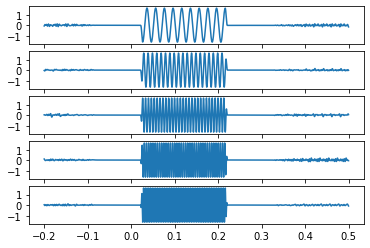

In [8]:
# Plot the stim signals
n_samples = len(stim_50)
t = np.linspace(RAW_TMIN, RAW_TMAX, n_samples, endpoint = False)

fig, axs = plt.subplots(5)
axs[0].plot(t, stim_50)
axs[1].plot(t, stim_100)
axs[2].plot(t, stim_150)
axs[3].plot(t, stim_200)
axs[4].plot(t, stim_250)

In [9]:
# Broadcast sine waves by number of epochs
sine_50_epochs = [stim_50]*n_epochs
sine_100_epochs = [stim_100]*n_epochs
sine_150_epochs = [stim_150]*n_epochs
sine_200_epochs = [stim_200]*n_epochs
sine_250_epochs = [stim_250]*n_epochs

# Combine sine waves into a data array
data = np.stack((sine_50_epochs, 
                 sine_100_epochs,
                 sine_150_epochs,
                 sine_200_epochs,
                 sine_250_epochs,
                ), axis = 1)
print(np.shape(data)) # n_epochs, n_channels, n_samples

# Specify channel info
info = mne.create_info(ch_names = ['50haz', 
                                   '100hz',
                                   '150hz',
                                   '200hz',
                                   '250hz'],
                       ch_types = ['stim'] * 5,
                       sfreq = FS)

# Manually add channel info to match original data to stop mne from shouting at us, very hacky
info['custom_ref_applied'] = True
info['description'] = 'Anonymized using a time shift to preserve age at acquisition'
info['experimenter'] = 'mne_anonymize'
info['highpass'] = 30.0
info['line_freq'] = 60.0
info['lowpass'] = 270.0
event_id = {'100': 10001, '150': 10002, '200': 10003, '250': 10004, '50': 10005}

# Manually add info that is passed in through mne.EpochsArray instead of in the info dict, also very hacky
baseline = (-0.20000000298023224, 0.0)

# Create Epochs object
simulated_epochs = mne.EpochsArray(data, 
                                   info, 
                                   events = events, 
                                   tmin = RAW_TMIN, 
                                   event_id = event_id, 
                                   baseline = baseline)


(1922, 5, 3501)
Not setting metadata
1922 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/mne/io/meas_info.py:864: UserWarning: Avoid manually setting custom_ref_applied cannot be set directly. Please use method inst.set_eeg_reference() instead.
  warnings.warn(f"Avoid manually setting {self._attributes[key]}")
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/mne/io/meas_info.py:864: UserWarning: Avoid manually setting highpass cannot be set directly. Please use method inst.filter() instead.
  warnings.warn(f"Avoid manually setting {self._attributes[key]}")
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/mne/io/meas_info.py:864: UserWarning: Avoid manually setting lowpass cannot be set directly. Please use method inst.filter() instead.
  warnings.warn(f"Avoid manually setting {self._attributes[key]}")


0 bad epochs dropped


In [10]:
# Crop data
simulated_epochs = simulated_epochs.crop(tmin = TMIN,
                                         tmax = TMAX)
epochs = epochs.crop(tmin = TMIN)

In [11]:
# Combine original channels with simulated channels
combined_epochs = mne.epochs.add_channels_epochs([epochs, simulated_epochs])

### Compute coherence

In [12]:
data = combined_epochs.get_data()
freqs = np.array([50, 100, 150, 200, 250])
foi = np.stack((freqs - 5, freqs + 5)).T
# fmin = freq - 5
# fmax = freqs + 5
# foi = np.concatenate(fmin, fmax)
foi

array([[ 45,  55],
       [ 95, 105],
       [145, 155],
       [195, 205],
       [245, 255]])

In [12]:
np.shape(data)

(1922, 67, 1251)

In [13]:
# Set indices of channel pairs to compute coherence across
stim_indices = np.array([62, 63, 64, 65, 66]*62)
chan_indices = np.repeat(np.arange(1, 63, 1), 5)
indices = (stim_indices, chan_indices)

In [14]:
spectral_connectivity_time(combined_epochs, indices = indices, sfreq = FS, foi = foi)

Adding metadata with 3 columns


UnboundLocalError: local variable 'f_vec' referenced before assignment

In [15]:
# coh = EpochSpectralConnectivity(
#     data, freqs, n_nodes = 310, indices='all',method = 'imcoh', mode='fourier')
# freqs = coh.freqs

print('Frequencies in Hz over which coherence was averaged for 50 Hz: ')
print(freqs[0])
print('Frequencies in Hz over which coherence was averaged for 100 Hz: ')
print(freqs[1])
print('Frequencies in Hz over which coherence was averaged for 150 Hz: ')
print(freqs[2])
print('Frequencies in Hz over which coherence was averaged for 200 Hz: ')
print(freqs[3])
print('Frequencies in Hz over which coherence was averaged for 250 Hz: ')
print(freqs[4])

ValueError: conflicting sizes for dimension 'freqs': length 1251 on the data but length 5 on coordinate 'freqs'

In [ ]:
# TRY SOME ANALYSES WITH THIS 

coh = spectral_connectivity_epochs(
    data, method='coh', mode='fourier', indices=indices,
    sfreq=FS, fmin=fmin, fmax=fmax, faverage=True, n_jobs=1)
freqs = coh.freqs

print('Frequencies in Hz over which coherence was averaged for 50 Hz: ')
print(freqs[0])
print('Frequencies in Hz over which coherence was averaged for 100 Hz: ')
print(freqs[1])
print('Frequencies in Hz over which coherence was averaged for 150 Hz: ')
print(freqs[2])
print('Frequencies in Hz over which coherence was averaged for 200 Hz: ')
print(freqs[3])
print('Frequencies in Hz over which coherence was averaged for 250 Hz: ')
print(freqs[4])



In [34]:
np.shape(coh) # n_chans * n_stim, n_freqs
# want it to be by n_trials also
print(np.shape(coh.get_data()))
coh.get_data()[120:125,:]
type(coh)
# COMPUTE COHERENCE SEPARATELY FOR EACH CONDITIONSNSN!!!

# TRY THE COH THAT ENDS IN TIME

(310, 5)


mne_connectivity.base.SpectralConnectivity

In [ ]:
# Create data frame (chan, stim_chan, coh_at_50hz, coh_at_100hz, coh_at_150, coh_at_200, coh_at_250)

In [ ]:
epochs.events

In [ ]:
mne.pick_types(combined_epochs.info, stim = True, eeg = True)

In [ ]:
mne.pick_types(simulated_epochs.info, stim = True)